We base the physical parameters on a system like [Marago:2001] so we can explore damping of the normal modes of the system.  They have trapping frequencies of $\omega_y=\omega_z = 128$Hz and $\omega_x = \sqrt{8}\omega_y$ and $N = 2\times 10^4$ particles.  In the TF approximation at $T=0$ this corresponds to $\mu = $

[Marago:2001]: http://dx.doi.org/10.1103/PhysRevLett.86.3938 (Onofrio Marag\`o, Gerald Hechenblaikner, Eleanor Hodby, and Christopher Foot, "Temperature Dependence of Damping and Frequency Shifts of the Scissors Mode of a Trapped Bose-Einstein Condensate", Phys. Rev. Lett. 86, 3938--3941 (2001) )

In [1]:
import mmf_setup;mmf_setup.nbinit()

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


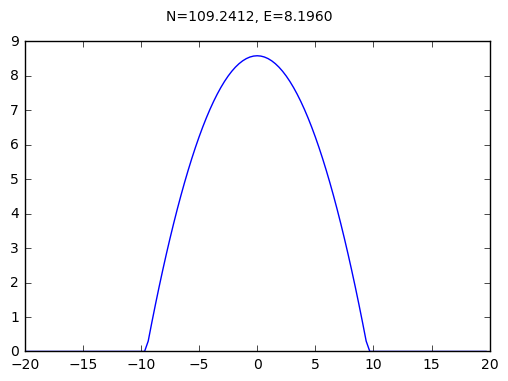

In [2]:
%pylab inline --no-import-all
from IPython.display import display, clear_output
import bec; reload(bec)
from bec import State, u
s = State(Nxyz=(128,), Lxyz=(40*u.micron,), N=1e5)
s.plot()

## Testing

To test the code, we will set $g=0$ and use the exact solution for the Harmonic Oscillator:

$$
  \psi(x) \propto e^{-(x/a)^2/2}, \qquad
  a^2 = \frac{\hbar}{m\omega}
$$

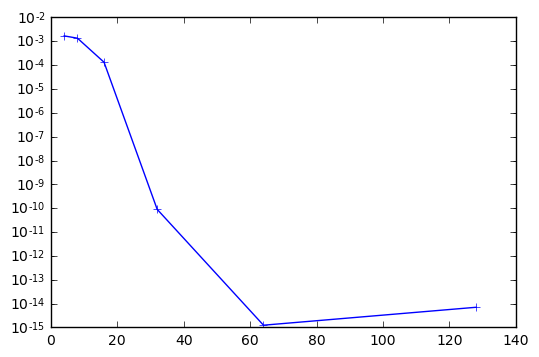

In [98]:
def get_err(N=128, L=24*u.micron):
    s = State(Nxyz=(N,), Lxyz=(L,), N=1e5)
    s.g = 0
    a = np.sqrt(u.hbar/u.m/s.ws[0])
    x = s.xyz[0]
    psi_0 = np.exp(-(x/a)**2/2.0)
    s[...] = psi_0
    s.normalize()
    dy = s.empty()
    s.compute_dy_dt(dy=dy, subtract_mu=True)
    return abs(dy[...]).max()

Ns = 2**np.arange(2,8)
errs = map(get_err, Ns)
plt.semilogy(Ns, errs, '-+')

Why are $L=23$microns and $N=2^6$ optimal?

In [101]:
s = State(Nxyz=(46,), Lxyz=(23*u.micron,))
a = np.sqrt(u.hbar/u.m/s.ws[0])
L, N = s.Lxyz[0], s.Nxyz[0]
k_max = np.pi*(N-2)/L   # For Khalid...
print k_max, s.kxyz[0].max()
print np.exp(-(L/2/a)**2/2)   # Wavefunction drops by factor of macheps

(2.12353149896+0j)
6.0100033373 6.0100033373
9.87009441159e-15


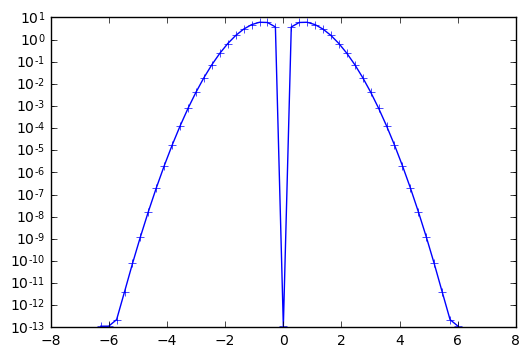

In [97]:
psi_0 = s.xyz[0]*np.exp(-(s.xyz[0]/a)**2/2)
plt.semilogy(np.fft.fftshift(s.kxyz[0]), 
         np.fft.fftshift(abs(np.fft.fft(psi_0))), '-+')

So we see that for the ground state $k$ needs to go up to $6$.

## Exact Solution with Interactions

Populating the interactive namespace from numpy and matplotlib


1.2001072726244708e-14

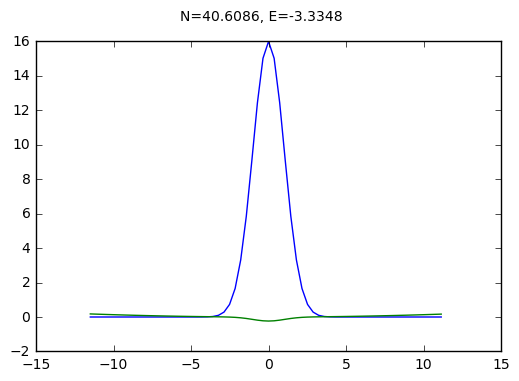

In [2]:
%pylab inline --no-import-all
from IPython.display import display, clear_output
import bec; reload(bec)
from bec import State, u

s = State(Nxyz=(64,), Lxyz=(23*u.micron,), N=1e5)
a = np.sqrt(u.hbar/u.m/s.ws[0])
x = s.xyz[0]
psi_0 = np.exp(-(x/a)**2/2)

class State1(State):
    def __init__(self, *v, **kw):
        State.__init__(self, *v, **kw)
        a = np.sqrt(u.hbar/u.m/self.ws[0])
        x = self.xyz[0]
        k = 1./2./a**2
        psi_0 = 4.0*np.exp(-(x/a)**2/2)
        n_0 = abs(psi_0)**2
        self._V_ext = (u.hbar**2/2.0/u.m*(4*(k*x)**2 - 2*k) - self.g*n_0)
        self.data[...] = psi_0
        self.get_Vext = lambda: self._V_ext
        self.pre_evolve_hook()
        
s = State1(Nxyz=(64,), Lxyz=(23*u.micron,))
s.plot()
plt.plot(x, s.get_Vext())
dy = s.empty()
s.compute_dy_dt(dy=dy, subtract_mu=False)
abs(dy[...]).max()

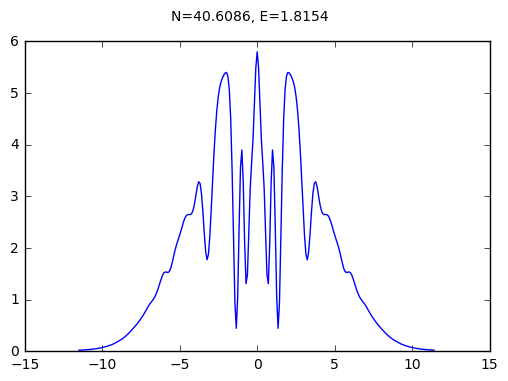

In [12]:
from mmfutils.contexts import NoInterrupt
from pytimeode.evolvers import EvolverSplit, EvolverABM
from IPython.display import display, clear_output

s = State1(Nxyz=(64*4,), Lxyz=(23*u.micron,))
assert np.allclose(s._N, s.get_N())

s[...] = 1.0
s.normalize()
s.cooling_phase = 1j

E_max = u.hbar**2*np.abs(s.kxyz).max()**2/2.0/u.m

#e = EvolverSplit(s, dt=0.01*u.hbar/E_max, normalize=True)
e = EvolverABM(s, dt=0.1*u.hbar/E_max, normalize=True)

with NoInterrupt(ignore=True) as interrupted:
    while e.y.t < 4*u.ms and not interrupted:
        e.evolve(100)
        plt.clf()
        e.y.plot()
        display(plt.gcf())
        clear_output(wait=True)

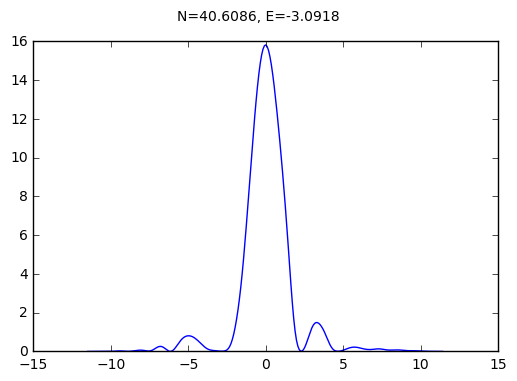

In [21]:
from mmfutils.contexts import NoInterrupt
from pytimeode.evolvers import EvolverSplit, EvolverABM
from IPython.display import display, clear_output

s = State1(Nxyz=(64*4,), Lxyz=(23*u.micron,))
s *= np.sign(s.xyz[0] - 0.5)
s.cooling_phase = 1 + 0.01j

E_max = u.hbar**2*np.abs(s.kxyz).max()**2/2.0/u.m
#e = EvolverSplit(s, dt=0.01*u.hbar/E_max, normalize=True)
e = EvolverABM(s, dt=0.5*u.hbar/E_max, normalize=True)

with NoInterrupt(ignore=True) as interrupted:
    while e.y.t < 40*u.ms and not interrupted:
        e.evolve(100)
        plt.clf()
        e.y.plot()
        display(plt.gcf())
        clear_output(wait=True)

In [ ]:
%pylab inline --no-import-all
from IPython.display import display, clear_output

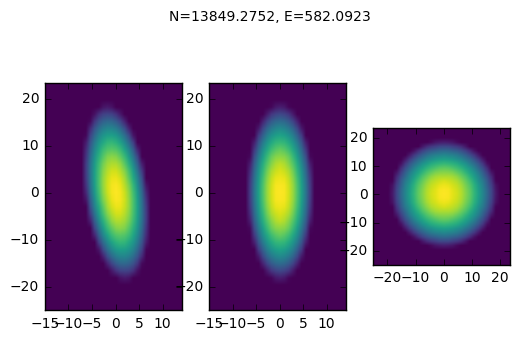

In [50]:
import bec;reload(bec)
from pytimeode.evolvers import EvolverABM
from mmfutils.contexts import NoInterrupt
from bec import State, u

s = State()
s.cooling_phase = 1j
s.t = -100*u.ms
e = EvolverABM(s, dt=0.001)
with NoInterrupt(ignore=True) as interrupted:
    while not interrupted:
        e.evolve(500)
        plt.clf()
        e.y.plot()
        display(plt.gcf())
        clear_output(wait=True)
        

(0.06546290960430827, (0.069329852780939283+0j))

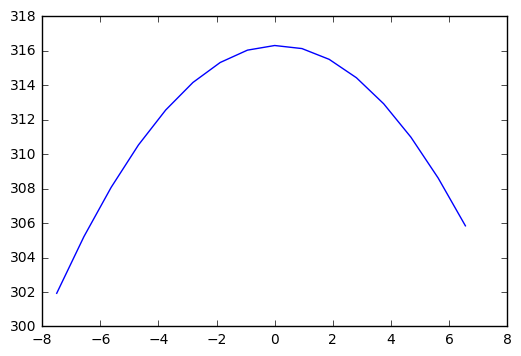

In [38]:
s = e.get_y()
n = s.get_density()
x, y, z = s.xyz
plt.plot(x.ravel(), n.sum(axis=-1).sum(axis=-1))
s.mu, s._mu